In [11]:
import obspy
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt
from axikernels.core.handlers import element_output
from obspy.geodetics.base import gps2dist_azimuth
client = Client("IRIS")

## Importing real data

In [12]:
# Import earthquake data
start_time = obspy.UTCDateTime("2012-12-10T16:53:00")  # Replace with the start time of the earthquake
end_time = obspy.UTCDateTime("2012-12-10T16:53:20")  # Replace with the end time of the earthquake
event = client.get_events(starttime=start_time, endtime=end_time, minmagnitude=7.1)
# Import station data
inventory = client.get_stations(network="IU", station="MAJO", channel="BH*", location='00', level="response")
# Import wavefield data
real_data = obspy.read('data/2012-12-10-mw71-banda-sea.miniseed')

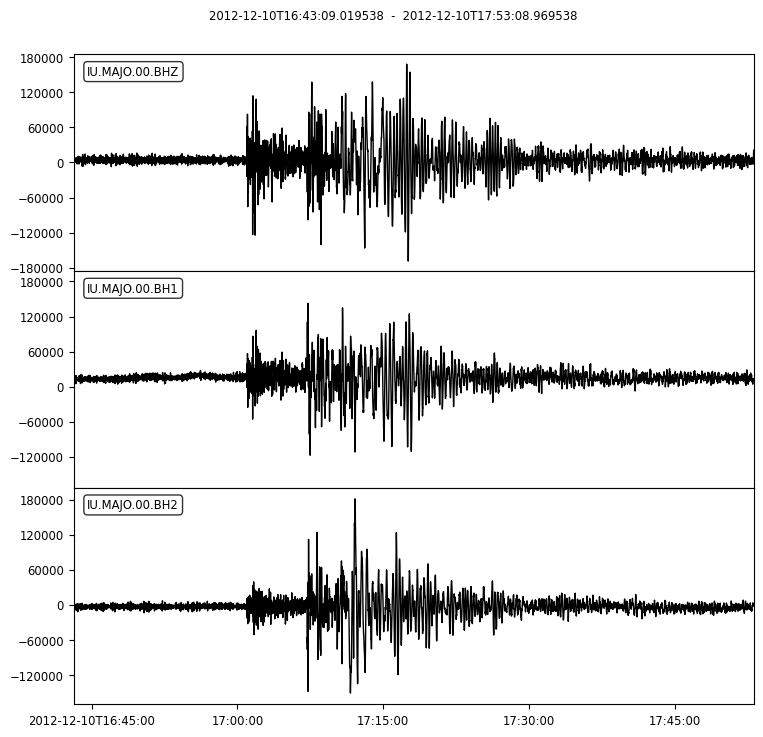

In [13]:
%matplotlib inline
# Select specific station
selected_stream = real_data.select(station='MAJO', location='00')
selected_stream.plot()
plt.show()

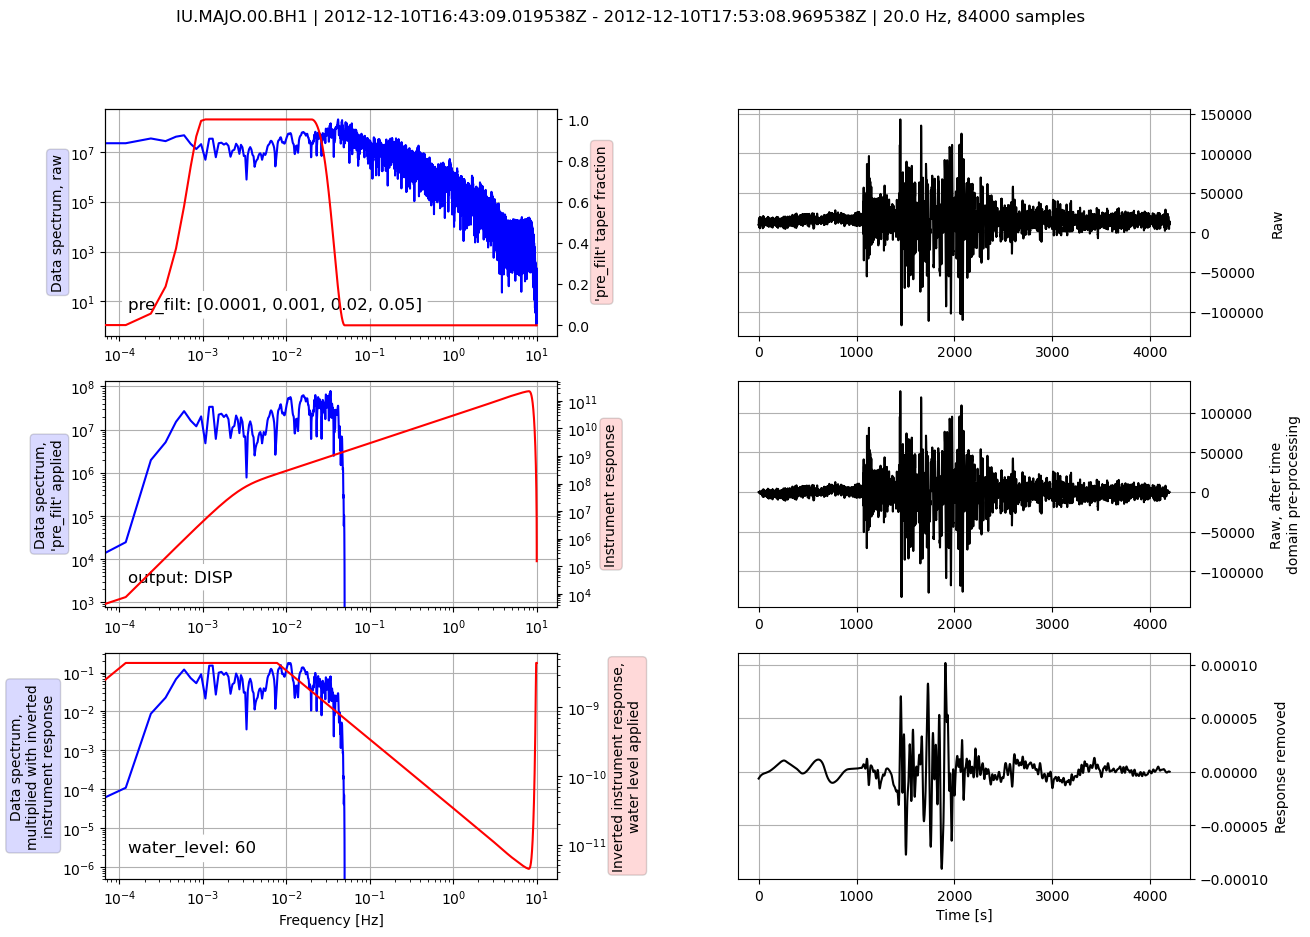

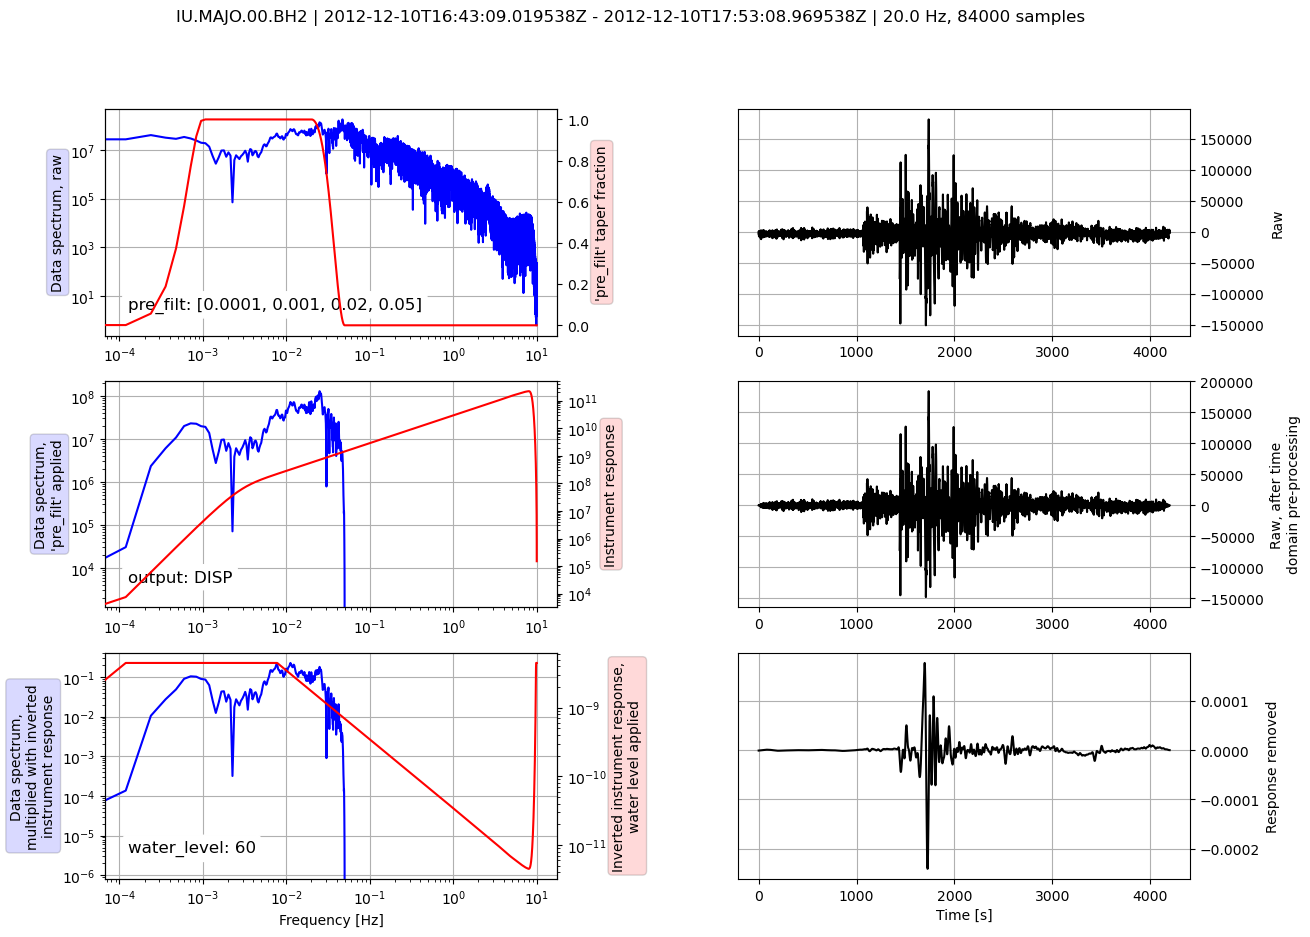

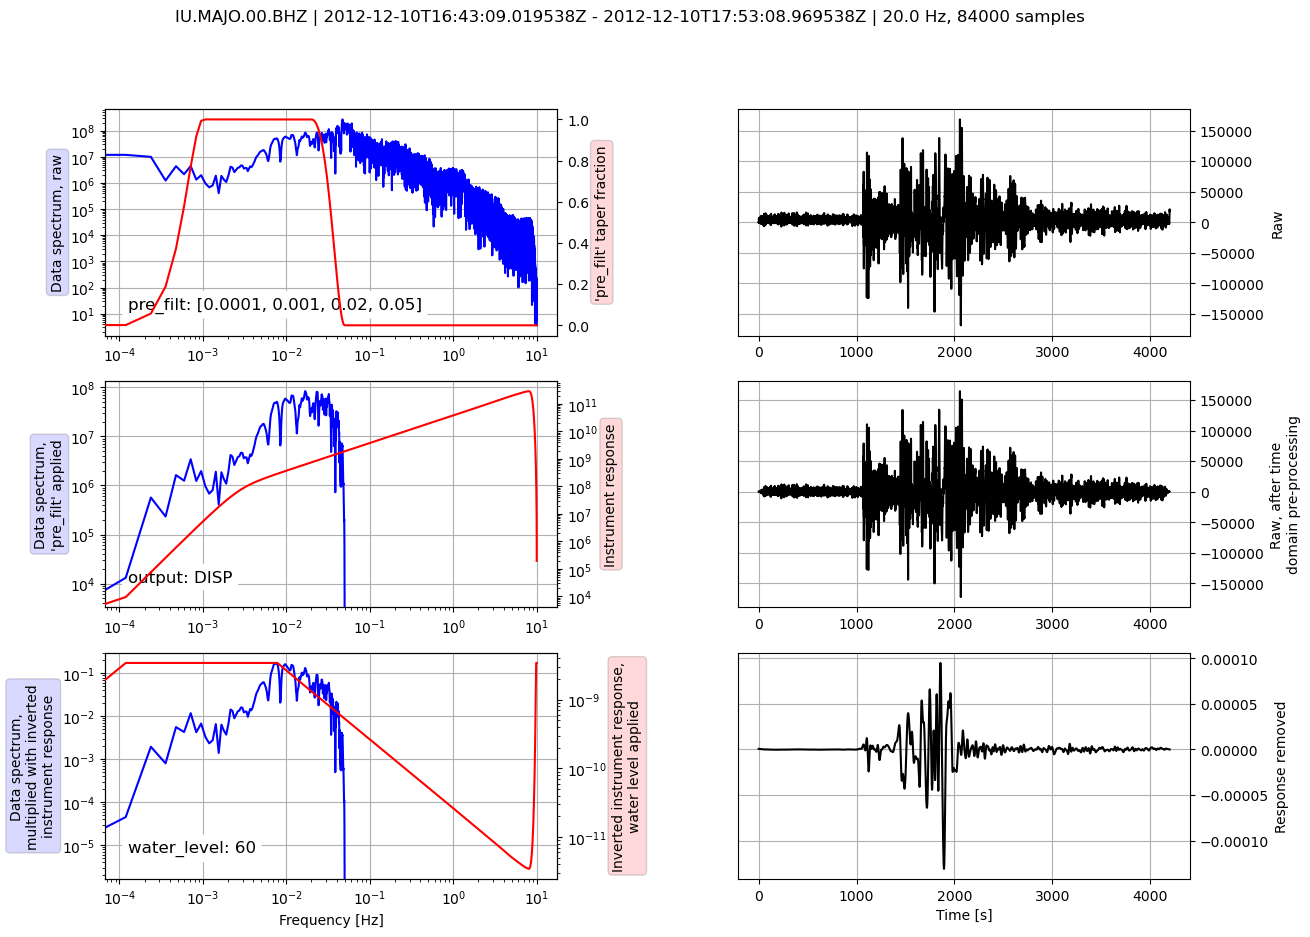

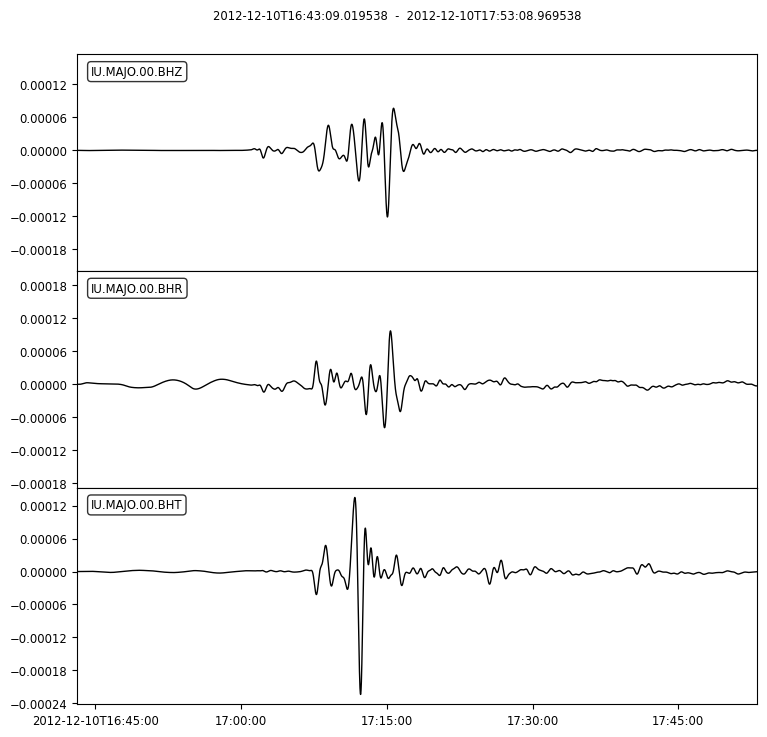

In [14]:
# Get station and event coordinates as they will be needed later
station_lat = inventory[0][0].latitude
station_lon = inventory[0][0].longitude
event_lat = event[0].origins[0].latitude
event_lon = event[0].origins[0].longitude
back_azimuth = gps2dist_azimuth(lat1=event_lat, lon1=event_lon,
                                lat2=station_lat, lon2=station_lon,
                                a=6378137.0, f=0.0033528106647474805)[2]
# Process the station to match the period of the synthetic data
selected_stream.remove_response(inventory=inventory,
                                pre_filt=[1e-4, 1e-3, 0.02, 0.05],
                                output="DISP", water_level=60,
                                plot=True)
selected_stream.detrend()
selected_stream.filter('bandpass', freqmin=0.001, freqmax=0.02)
selected_stream.rotate(method='->ZNE', inventory=inventory, back_azimuth=back_azimuth)
selected_stream.rotate(method='NE->RT', inventory=inventory, back_azimuth=back_azimuth)
selected_stream.plot()
plt.show()

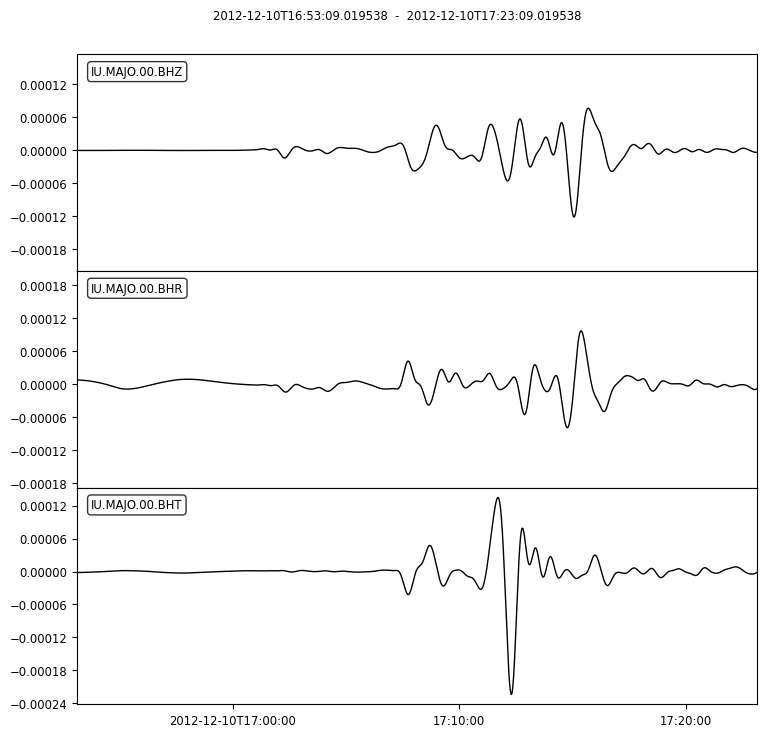

In [15]:
selected_stream.trim(starttime=selected_stream[0].stats.starttime + 10*60, endtime=selected_stream[0].stats.starttime + 40*60).plot()
plt.show()

## Reproducing the earthquake

We first try to reproduce the wavefield of the real even in a 1D Earth as well as we can. 

1. We use the *prem_ani.bm* basemodel file to create a mesh (anisotropic,   anelastic, but 1D) using the command:

    ```bash
    python -m salvus_mesh_lite.interface AxiSEM -o prem_ani_50s.e --overwrite_file --basic.model model.bm --basic.period 50
    ```
    Then we make sure to use this new mesh in the inparam.model.yaml file.

2. For the inparam.nr.yaml we just need to make sure to use a constant nr=5 in the whole domain since we are doing a 1D simulation (this is where the speed-up happens compared to other full 3D wave solvers).
3. For the source we use the coordinates, depth, abd moment tensor that is found on IRIS. This should give a good enough approximation of the source for our purposes. 
4. Finally, in the inparam.output.yaml we will put 3 element groups: for mantle, outer core (liquid), and inner core. Even though the simulation runs using 16 GLL points on each elements, we will output only 9 for saving memory. 
5. Run axisem3d (the size of the output file will be about 39GB! And the duration is about 0.8 cpu hours on a high end cpu. Maximum RAM usage is about 8GB. Make sure you have sufficient overhead for memory and disk.)



In [16]:
forward_1D_simulation = element_output.ElementOutput('data/1D_SIMULATION/output/elements')
station_coordinates = inventory.get_coordinates('BK.CMB.00.BHZ')
station_point = [6371000 - station_coordinates['elevation'], station_coordinates['latitude'], station_coordinates['longitude']]
forward_1D_simulation.stream(points=[station_point], channels=['UR', 'UT', 'UZ'])

No catalogues were found.


FileNotFoundError: [Errno 2] No such file or directory: 'data/1D_SIMULATION/output/elements/mantle'